# Lesson 5: Exploring Multiple Modalities with CLIP

CLIP:
- concepts
- embedding text and images
- measuring similarity
- Use as a loss (imstack demo)
- Need for transformations
- export some functions for later
- CLOOB

![clip diagram](https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/CLIP.png)

They train an image encoder and a text encoder simultaneously on a dataset of 400 million (image, text) pairs collected from the internet. Images and text are both transformed into encodings that can be directly compared.

From the paper, "To do this, CLIP learns a multi-modal embedding space by jointly training an image encoder and text encoder to maximize the cosine similarity of the image and text embeddings of the N real pairs in the batch while minimizing the cosine similarity of the embeddings of the N2 − N incorrect pairings. We optimize a symmetric cross entropy loss over these similarity scores"

The OpenAI team actually trained several different image encoders. Some were based on the ResNet architecture, a fairly popular Convolutional Neural Network type. Others were based on something called a Vision Transformer. The text encoder is also a transformer model. We haven't covered transformer models yet - for now we just need to know that they're great at modelling sequence data like text, and it turns out that by representing an image as a sequence of smaller image patches they're pretty good at dealing with images too.

Let's load up CLIP and encode some different inputs and then see what we can do with this

In [ ]:
#|hide
from tglcourse.utils import *
import torch

## Loading CLIP models with OpenCLIP

You can use pretrained CLIP models in a few different ways. There is [OpenAI's github repository](https://github.com/openai/CLIP) or the HuggingFace implementations, but I like the [OpenCLIP project](https://github.com/mlfoundations/open_clip) which includes both OpenAI versions and a number of new models trained in the open on public datasets like LAION. 

Let's import the library and see what models are available:

In [ ]:
import open_clip

print(open_clip.list_pretrained())

[('RN50', 'openai'), ('RN50', 'yfcc15m'), ('RN50', 'cc12m'), ('RN50-quickgelu', 'openai'), ('RN50-quickgelu', 'yfcc15m'), ('RN50-quickgelu', 'cc12m'), ('RN101', 'openai'), ('RN101', 'yfcc15m'), ('RN101-quickgelu', 'openai'), ('RN101-quickgelu', 'yfcc15m'), ('RN50x4', 'openai'), ('RN50x16', 'openai'), ('RN50x64', 'openai'), ('ViT-B-32', 'openai'), ('ViT-B-32', 'laion400m_e31'), ('ViT-B-32', 'laion400m_e32'), ('ViT-B-32', 'laion2b_e16'), ('ViT-B-32', 'laion2b_s34b_b79k'), ('ViT-B-32-quickgelu', 'openai'), ('ViT-B-32-quickgelu', 'laion400m_e31'), ('ViT-B-32-quickgelu', 'laion400m_e32'), ('ViT-B-16', 'openai'), ('ViT-B-16', 'laion400m_e31'), ('ViT-B-16', 'laion400m_e32'), ('ViT-B-16-plus-240', 'laion400m_e31'), ('ViT-B-16-plus-240', 'laion400m_e32'), ('ViT-L-14', 'openai'), ('ViT-L-14', 'laion400m_e31'), ('ViT-L-14', 'laion400m_e32'), ('ViT-L-14', 'laion2b_s32b_b82k'), ('ViT-L-14-336', 'openai'), ('ViT-H-14', 'laion2b_s32b_b79k'), ('ViT-g-14', 'laion2b_s12b_b42k')]


Following the demo code on GitHub, here's loading a popular model:

In [ ]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')

### Aside: Model Naming

What does 'ViT-B/32' mean? This uses a Vision Transformer (ViT) as the image encoder, with an image patch size of 32 (larger patch size means fewer patches per image at a given size, and thus faster/smaller models) and the 'Base' size model. I believe the size order is 'Base' (B), Large (L), Huge (H) and ginormous (g) but don't quote me on that! Generally the larger models with the smaller patch sizes will need more memory and compute in exchenge for better performance. Most models were trained on 224px input images but there are variants trained on larger image sizes - again they will be more computationally expensive to run. 'RN50' style names mean the vision encoder is based on a Resnet50 architecture instead of a vision transformer. 

Generally I like to stick with the smaller models, but you can experiment with swapping in larger variants or using multiple models and combining the results.

## Preprocessing


In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Image -> Features

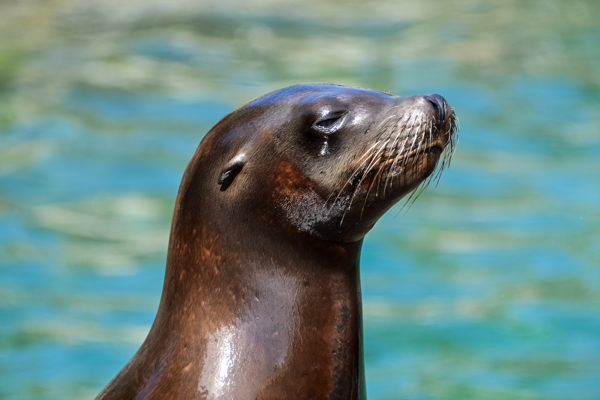

In [ ]:
input_image = pil_from_url('https://images.pexels.com/photos/185032/pexels-photo-185032.jpeg?').resize((600, 400))
input_image

In [ ]:
image = preprocess(input_image).unsqueeze(0)
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    
print('image.shape:', image.shape, 'image_features.shape:', image_features.shape)

image.shape: torch.Size([1, 3, 224, 224]) image_features.shape: torch.Size([1, 512])


## Text -> Features

In [ ]:
text = open_clip.tokenize(["a diagram", "a dog", "a cat"])
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text)
    
print('Tokenized text shape:', text.shape)
print('text_features.shape', text_features.shape)

Tokenized text shape: torch.Size([3, 77])
text_features.shape torch.Size([3, 512])


## Computing Similarity

In [ ]:
# Computing similarities
def probability_scores(image_features, text_features):
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    return text_probs

torch.set_printoptions(precision=3)
print("Label probs:", probability_scores(image_features, text_features))  # Apparently closest guess is 'a dog' - do you agree?

Label probs: tensor([[0.022, 0.964, 0.014]])


In [ ]:
(image_features/image_features.norm(dim=-1, keepdim=True))@(text_features/text_features.norm(dim=-1, keepdim=True)).T

tensor([[0.143, 0.180, 0.138]])

In [ ]:
torch.nn.functional.cosine_similarity(image_features, text_features)

tensor([0.143, 0.180, 0.138])

In [ ]:
torch.nn.functional.cosine_similarity(image_features, text_features).softmax(dim=-1)

tensor([0.330, 0.342, 0.328])

In [ ]:
# TODO explain cosine sim and softmax

## Image Search

In [ ]:
import glob
image_files = glob.glob('images/*.png') + glob.glob('images/*.jpeg')
len(image_files)

9

In [ ]:
image_features = []
for fn in image_files:
    im = load_image_pil(fn)
    image_features.append(model.encode_image(preprocess(im).unsqueeze(0)))
image_features = torch.cat(image_features)
image_features.shape

torch.Size([9, 512])

Similarities: [0.12317517 0.07863379 0.11897033 0.0889878  0.07535253 0.07106286
 0.12133323 0.27785698 0.13541897]
Argmax: tensor(7)
Best image match:


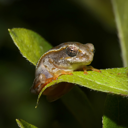

In [ ]:
text = open_clip.tokenize(["a frog"])
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text)
similarities = torch.nn.functional.cosine_similarity(text_features, image_features)
print('Similarities:', similarities.detach().numpy())
print('Argmax:', similarities.argmax()) # TODO explain
print('Best image match:')
load_image_pil(image_files[similarities.argmax()]).resize((128, 128))

## Using CLIP as a loss function

Now we're ready to see how this is used to guide image generation methods to match a text prompt!

We can use cosine similarity, but in testing people have found an alternative that seems to work better: Great Circle Distance Squared.

You can see an implementation in the generators bonus notebook (todo link) but as an exercise let's dig into a notebook from the golden age of VQGAN+CLIP to see how much we can understand and what other tricks are in use to get the best images possible from that technique:

In [ ]:
# TODO cosine sim

In [ ]:
# TODO great circle dist

In [ ]:
# TODO demo optimizing towards a CLIP prompt

In [ ]:
# TODO video looking at Remi's multi-perceptor notebook.

Page stats: Total Hits: [![HitCount](https://hits.dwyl.com/johnowhitaker/tglcourse.svg?style=flat-square&show=unique)](http://hits.dwyl.com/johnowhitaker/tglcourse)
Page visitors:
![visitor badge](https://page-views.glitch.me/badge?page_id=tglcourse.l05)